In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import timeit
import h5py
from pathlib import Path
import numpy as np
from itertools import product
import pickle
import scipy.special
import scipy.stats
from math import exp
import multiprocessing
import functools

from montecarlo import DataLogger

%matplotlib inline
np.seterr(all='warn')
textwidth = 6.268
mpl.rcParams['figure.dpi'] = 70
default_figargs = dict(figsize = (textwidth,textwidth))

from montecarlo import *

In [5]:
%%time
from direct_partition_functions import binder_parrallel
n_cumulants = 5
T = np.linspace(0.05, 5, 20)
beta = 1/T
Ns = [6,8,12,14,16]
Us = [0,1,10]
Js = [0, 0.1, 1, 5]
t = 1
alpha = 1.5
binder_params = dict(t = t, alpha = alpha, mu = 0, normalise = True)

binder_cumulants = np.ones(shape = (len(Js), len(Us), len(Ns), 2, n_cumulants, len(beta)), dtype = np.float64)
with multiprocessing.Pool(multiprocessing.cpu_count() - 1) as pool:
    for slice1, J in zip(binder_cumulants, Js):
        for slice2, U in zip(slice1, Us):
            for slice3, system_size in zip(slice2, Ns):
                print(system_size, U, J)
                result = np.array([binder_parrallel(system_size = system_size, mu = 0, beta = b, U = U, J = J, t = t, alpha = alpha, pool=pool) for b in beta])
                np.copyto(slice3, np.einsum('ijk->jki',result))

np.savez('./pickled_data/binder_cumulants_direct_2.npz', 
         T=T, Ns=Ns, Us=Us, Js = Js, n_cumulants=n_cumulants, t=t, alpha = alpha, beta = beta,
         binder_cumulants=binder_cumulants)
print('done')

6 0 0
8 0 0
12 0 0
14 0 0
16 0 0
6 1 0
8 1 0
12 1 0
14 1 0
16 1 0
6 10 0
8 10 0
12 10 0
14 10 0
16 10 0
6 0 0.1
8 0 0.1
12 0 0.1
14 0 0.1
16 0 0.1
6 1 0.1
8 1 0.1
12 1 0.1
14 1 0.1
16 1 0.1
6 10 0.1
8 10 0.1
12 10 0.1
14 10 0.1
16 10 0.1
6 0 1
8 0 1
12 0 1
14 0 1
16 0 1
6 1 1
8 1 1
12 1 1
14 1 1
16 1 1
6 10 1
8 10 1
12 10 1
14 10 1
16 10 1
6 0 5
8 0 5
12 0 5
14 0 5
16 0 5
6 1 5
8 1 5
12 1 5
14 1 5
16 1 5
6 10 5
8 10 5
12 10 5
14 10 5
16 10 5
done
CPU times: user 13min 36s, sys: 43.5 s, total: 14min 19s
Wall time: 33min 43s


In [7]:
%time
from time import time
from montecarlo import *
N_steps = int(5 * 1000)
N_burn_in = int(1 * 1000)

MCMC_params = dict(
        N_steps = N_steps, N_burn_in = N_burn_in, 
        state=np.arange(system_size)%2, 
        logger = Magnetisation_cumulants(N_cumulants = n_cumulants),
        proposal = p_multi_site_uniform_reflect,
        #proposal_args = dict(lam = 4),
        accept_function = simple_accept,
    )

def compute(beta, **kwargs):
    kwargs['parameters']['beta'] = beta
    return FK_mcmc_2(**kwargs)

mcmc_binder_cumulants = np.zeros(shape = (len(Js), len(Us), len(Ns), 2, n_cumulants, len(beta)), dtype = np.float64)
with multiprocessing.Pool(multiprocessing.cpu_count() - 1) as pool:
    for slice1, J in zip(mcmc_binder_cumulants, Js):
        for slice2, U in zip(slice1, Us):
            for slice3, system_size in zip(slice2, Ns):
                t0 = time()
                these_params = binder_params.copy()
                these_params.update(J=J, U=U)
                
                MCMC_params.update(state = np.arange(system_size)%2)
                curried = functools.partial(compute, parameters = these_params, **MCMC_params)
                result = pool.map(curried, beta)
                #(beta, [non_central/central], powers) -> ([non_central/central], powers, beta)
                np.copyto(slice3, np.einsum('ijk->jki',result))
                print(U, J, system_size, f'{time() - t0:.0f} seconds')

np.savez('./pickled_data/binder_cumulants_mcmc_2.npz', 
         N_steps = N_steps, N_burn_in = N_burn_in,
         mcmc_binder_cumulants = mcmc_binder_cumulants)
print('done!')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.48 µs
Warning, p_acc = 1.0, {'t': 1, 'alpha': 1.5, 'mu': 0, 'normalise': True, 'J': 0, 'U': 0, 'beta': 0.7392996108949416, 'J_matrix': 'suppressed for brevity'}
Warning, p_acc = 1.0, {'t': 1, 'alpha': 1.5, 'mu': 0, 'normalise': True, 'J': 0, 'U': 0, 'beta': 20.0, 'J_matrix': 'suppressed for brevity'}
Warning, p_acc = 1.0, {'t': 1, 'alpha': 1.5, 'mu': 0, 'normalise': True, 'J': 0, 'U': 0, 'beta': 0.9156626506024095, 'J_matrix': 'suppressed for brevity'}
Warning, p_acc = 1.0, {'t': 1, 'alpha': 1.5, 'mu': 0, 'normalise': True, 'J': 0, 'U': 0, 'beta': 1.7511520737327186, 'J_matrix': 'suppressed for brevity'}
Warning, p_acc = 1.0, {'t': 1, 'alpha': 1.5, 'mu': 0, 'normalise': True, 'J': 0, 'U': 0, 'beta': 1.20253164556962, 'J_matrix': 'suppressed for brevity'}
Warning, p_acc = 1.0, {'t': 1, 'alpha': 1.5, 'mu': 0, 'normalise': True, 'J': 0, 'U': 0, 'beta': 0.6199021207177813, 'J_matrix': 'suppressed for brevity'}
Warning, p_acc = 1.0, 

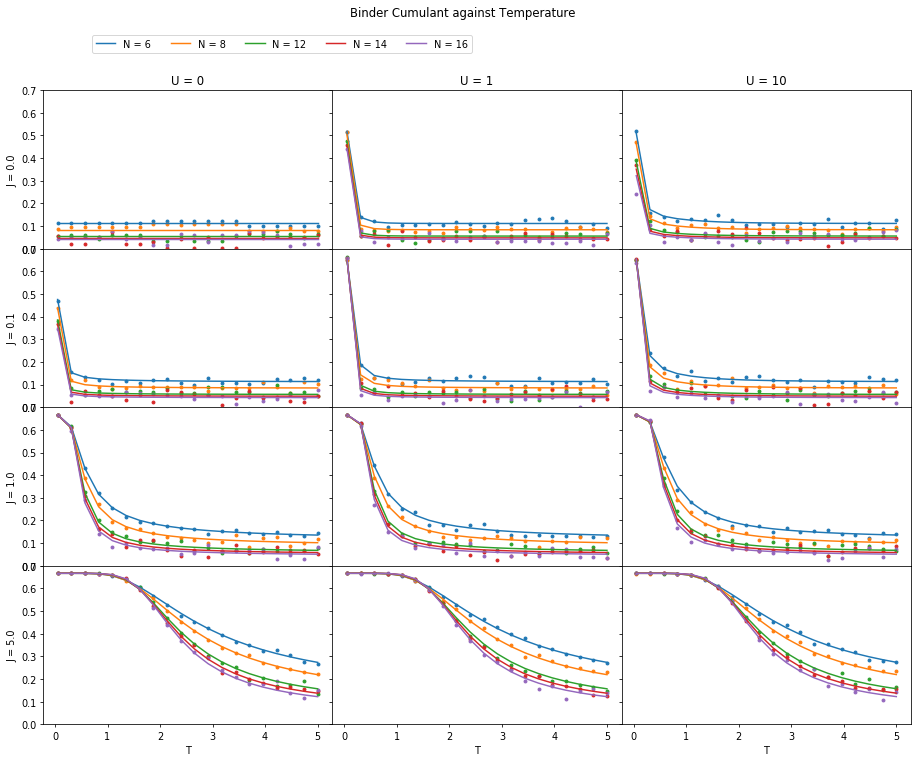

In [8]:
#%%time
from itertools import count
data = np.load('./pickled_data/binder_cumulants_direct_2.npz')
locals().update(data)
data = np.load('./pickled_data/binder_cumulants_mcmc_2.npz')
locals().update(data)

f, axes = plt.subplots(len(Js),len(Us),figsize = (len(Js)*4,len(Us)*4), sharex = 'col', sharey = 'row', gridspec_kw = dict(hspace = 0, wspace = 0))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
lines = np.zeros(shape = Ns.shape[0], dtype = object)

for row, mc_slice1, dir_slice1, J in zip(axes, mcmc_binder_cumulants, binder_cumulants, Js):
    for ax, mc_slice2, dir_slice2, U in zip(row, mc_slice1, dir_slice1, Us):
        for i, mc_slice3, dir_slice3, system_size in zip(count(), mc_slice2, dir_slice2, Ns):
            dir_Mf_moments, dir_Mf_central_moments = dir_slice3
            mc_Mf_moments, mc_Mf_central_moments = mc_slice3
            
            def binder_cumulant(central_moments): return 1 - central_moments[4]/(3*central_moments[2]**2)
            
            dir_binder_cumulant = binder_cumulant(dir_Mf_central_moments)
            lines[i], = ax.plot(T, dir_binder_cumulant, label = f'N = {system_size}')    
            ax.scatter(T, binder_cumulant(mc_Mf_central_moments), marker='.')    
            ax.set(ylim = (0, 0.7))
            
f.legend(lines, [l.get_label() for l in lines], loc = (0.1,0.93), ncol = len(lines))
f.suptitle('Binder Cumulant against Temperature')

for ax,U in zip(axes[0],Us): ax.set(title = f'U = {U}') 
for ax,J in zip(axes.T[0], Js): ax.set(ylabel = f'J = {J}') 
for ax in axes[-1]: ax.set(xlabel = 'T')
f.savefig('./Binder Cumulants.png')